# Singapore Budget Speeches Analysis

This notebook analyzes Singapore budget speeches from 1960 to 2025, focusing on:
1. **Number of speeches given by each minister**
2. **Length of speeches over the years**

## Setup and Import Libraries

First, we'll import the necessary libraries for data analysis and visualization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import sys

# Add extractor to path for importing speech_links
sys.path.append(str(Path.cwd().parent / 'extractor'))
from speech_links import budget_speech_links

# Ultra-minimal style
sns.set_style('white')
sns.despine()  # Remove all spines except bottom and left
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False  # Remove left spine too
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.size'] = 0  # Remove tick marks
plt.rcParams['ytick.major.size'] = 0

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


<Figure size 640x480 with 0 Axes>

## Load Data

Load all parquet files from the output_processor directory and combine them.

In [2]:
# Load all parquet files
output_processor_path = Path.cwd().parent / 'output_processor'
parquet_files = sorted(output_processor_path.glob('*.parquet'))

print(f"Found {len(parquet_files)} parquet files")

# Read and combine all parquet files
dfs = []
for file in parquet_files:
    df = pd.read_parquet(file)
    dfs.append(df)

# Combine all dataframes
df_all = pd.concat(dfs, ignore_index=True)

print(f"\n✓ Data loaded successfully!")
print(f"  Total speeches: {df_all['year'].nunique()} years")
print(f"  Total sentences: {len(df_all):,}")
print(f"  Year range: {df_all['year'].min()} - {df_all['year'].max()}")
print(f"  Columns: {df_all.columns.tolist()}")

df_all.head()

Found 66 parquet files

✓ Data loaded successfully!
  Total speeches: 66 years
  Total sentences: 39,707
  Year range: 1960 - 2025
  Columns: ['sentence_id', 'year', 'section_title', 'sentence_order', 'sentence_text', 'word_count', 'syllable_count', 'char_count']


,sentence_id,year,section_title,sentence_order,sentence_text,word_count,syllable_count,char_count
0,1960_0,1960,None,0,ANNUAL BUDGET STATEMENT,3,6,23
1,1960_1,1960,None,1,Dr Goh Keng Swee (Minister for Finance),7,10,39
2,1960_2,1960,None,2,The Minister for Finance (Dr Goh Keng Swee): M...,15,19,76
3,1960_3,1960,None,3,That the Assembly approves the financial polic...,14,20,84
4,1960_4,1960,None,4,"In ordinary times, the presentation of the bud...",19,30,111


## Add Minister Information

Merge the minister information from the speech_links dictionary with the speeches data.

In [3]:
# Create a dataframe with minister information
minister_info = []
for year, info in budget_speech_links.items():
    minister_info.append({
        'year': year,
        'minister': info['minister'],
        'date': info['date']
    })

df_ministers = pd.DataFrame(minister_info)

# Merge with the main dataframe
df_all = df_all.merge(df_ministers, on='year', how='left')

print(f"✓ Minister information added")
print(f"  Speeches with minister info: {df_all['minister'].notna().sum():,}")
print(f"\n  Ministers in dataset:")
for minister in df_all['minister'].unique():
    if pd.notna(minister):
        print(f"    - {minister}")

df_all.head()

✓ Minister information added
  Speeches with minister info: 39,707

  Ministers in dataset:
    - Goh Keng Swee
    - Lim Kim San
    - Hon Sui Sen
    - Goh Chok Tong
    - Dr Tony Tan Keng Yam
    - Dr Richard Hu Tsu Tau
    - Lee Hsien Loong
    - Tharman Shanmugaratnam
    - Heng Swee Keat
    - Lawrence Wong


,sentence_id,year,section_title,sentence_order,sentence_text,word_count,syllable_count,char_count,minister,date
0,1960_0,1960,None,0,ANNUAL BUDGET STATEMENT,3,6,23,Goh Keng Swee,1959-11-25
1,1960_1,1960,None,1,Dr Goh Keng Swee (Minister for Finance),7,10,39,Goh Keng Swee,1959-11-25
2,1960_2,1960,None,2,The Minister for Finance (Dr Goh Keng Swee): M...,15,19,76,Goh Keng Swee,1959-11-25
3,1960_3,1960,None,3,That the Assembly approves the financial polic...,14,20,84,Goh Keng Swee,1959-11-25
4,1960_4,1960,None,4,"In ordinary times, the presentation of the bud...",19,30,111,Goh Keng Swee,1959-11-25


## Analysis 1: Number of Speeches by Each Minister

Calculate and visualize how many budget speeches each minister delivered during their tenure.

In [4]:
# Count speeches per minister
speeches_by_minister = df_all.groupby('minister')['year'].nunique().sort_values(ascending=False)

print("Number of Budget Speeches by Minister:")
print("=" * 50)
for minister, count in speeches_by_minister.items():
    print(f"{minister:30s}: {count:2d} speeches")

Number of Budget Speeches by Minister:
Dr Richard Hu Tsu Tau         : 16 speeches
Goh Keng Swee                 :  9 speeches
Tharman Shanmugaratnam        :  9 speeches
Hon Sui Sen                   :  8 speeches
Heng Swee Keat                :  6 speeches
Lee Hsien Loong               :  5 speeches
Dr Tony Tan Keng Yam          :  4 speeches
Lawrence Wong                 :  4 speeches
Goh Chok Tong                 :  3 speeches
Lim Kim San                   :  2 speeches


## Analysis 2: Length of Speeches Over the Years

Calculate speech statistics by year including total words, sentences, and average words per sentence.

In [5]:
# Calculate speech statistics by year
yearly_stats = df_all.groupby('year').agg({
    'sentence_id': 'count',  # Number of sentences
    'word_count': 'sum',      # Total words
    'char_count': 'sum'       # Total characters
}).rename(columns={
    'sentence_id': 'total_sentences',
    'word_count': 'total_words',
    'char_count': 'total_chars'
})

# Calculate average words per sentence
yearly_stats['avg_words_per_sentence'] = yearly_stats['total_words'] / yearly_stats['total_sentences']

# Add minister information
yearly_stats = yearly_stats.merge(df_ministers[['year', 'minister']], 
                                  left_index=True, right_on='year', how='left')
yearly_stats = yearly_stats.set_index('year')

print("Speech Length Statistics by Year:")
print(yearly_stats.head(10))
print(f"\nOverall Statistics:")
print(f"  Average words per speech: {yearly_stats['total_words'].mean():,.0f}")
print(f"  Average sentences per speech: {yearly_stats['total_sentences'].mean():,.0f}")
print(f"  Average words per sentence: {yearly_stats['avg_words_per_sentence'].mean():.1f}")

Speech Length Statistics by Year:
      total_sentences  total_words  total_chars  avg_words_per_sentence  \
year                                                                      
1960              560        11784        69556               21.042857   
1961              715        14873        87310               20.801399   
1962              530        10277        60565               19.390566   
1963              463         9823        58450               21.215983   
1964              577        11916        70416               20.651646   
1965              382         7185        41801               18.808901   
1966              465         9894        58236               21.277419   
1967              517        10570        62742               20.444874   
1968              361         8111        47835               22.468144   
1969              518        10272        59660               19.830116   

           minister  
year                 
1960  Goh Keng Swee  


1. SPEECHES BY MINISTER
----------------------------------------------------------------------
  Dr Richard Hu Tsu Tau         : 16 speeches (1986-2001)
  Goh Keng Swee                 :  9 speeches (1960-1970)
  Tharman Shanmugaratnam        :  9 speeches (2007-2015)
  Hon Sui Sen                   :  8 speeches (1971-1978)
  Heng Swee Keat                :  6 speeches (2016-2021)
  Lee Hsien Loong               :  5 speeches (2002-2006)
  Dr Tony Tan Keng Yam          :  4 speeches (1982-1985)
  Lawrence Wong                 :  4 speeches (2022-2025)
  Goh Chok Tong                 :  3 speeches (1979-1981)
  Lim Kim San                   :  2 speeches (1966-1967)


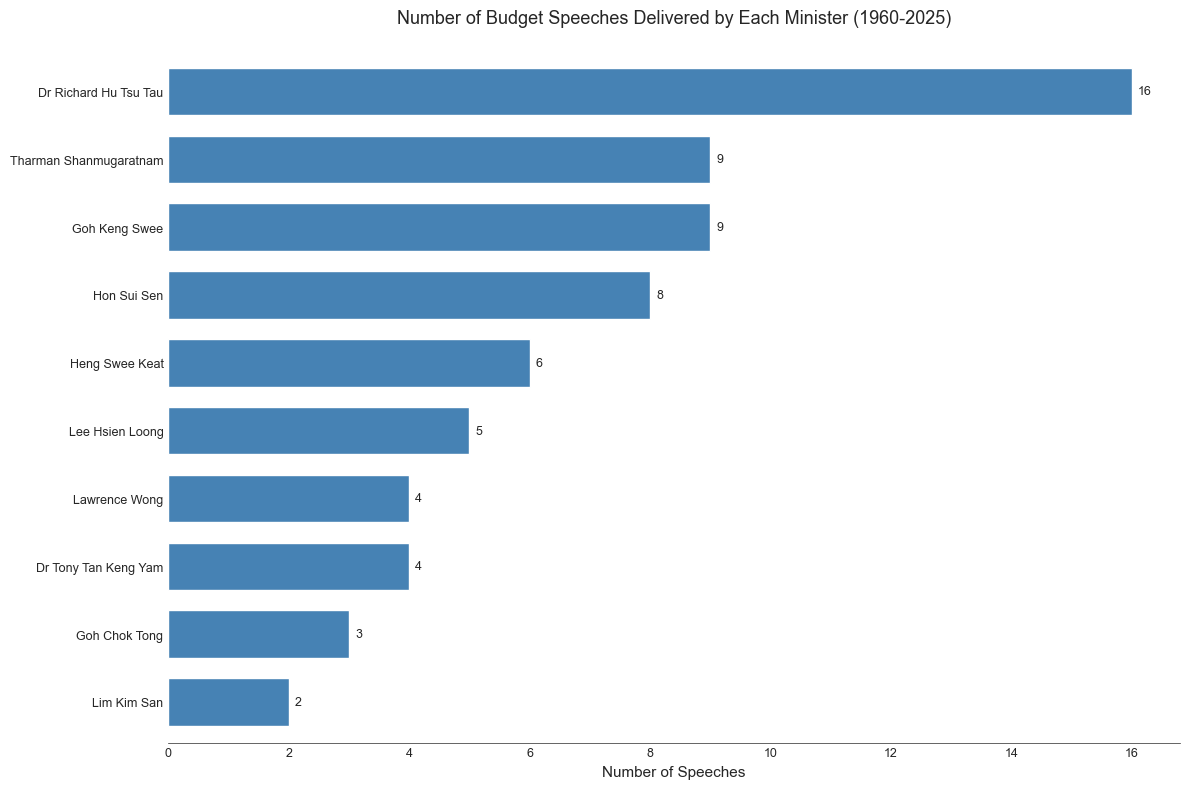

In [6]:
print("\n1. SPEECHES BY MINISTER")
print("-" * 70)
for minister, count in speeches_by_minister.items():
    years = yearly_stats[yearly_stats['minister'] == minister].index.tolist()
    year_range = f"{min(years)}-{max(years)}" if years else "N/A"
    print(f"  {minister:30s}: {count:2d} speeches ({year_range})")

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))
speeches_by_minister.sort_values(ascending=True).plot(kind='barh', ax=ax, color='steelblue', width=0.7)
ax.set_xlabel('Number of Speeches', fontsize=11)
ax.set_ylabel('')
ax.set_title('Number of Budget Speeches Delivered by Each Minister (1960-2025)', 
             fontsize=13, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', labelsize=9)
ax.tick_params(axis='y', labelsize=9)
ax.grid(False)

# Add value labels on bars
for i, v in enumerate(speeches_by_minister.sort_values(ascending=True)):
    ax.text(v + 0.1, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

### Total Words per Year

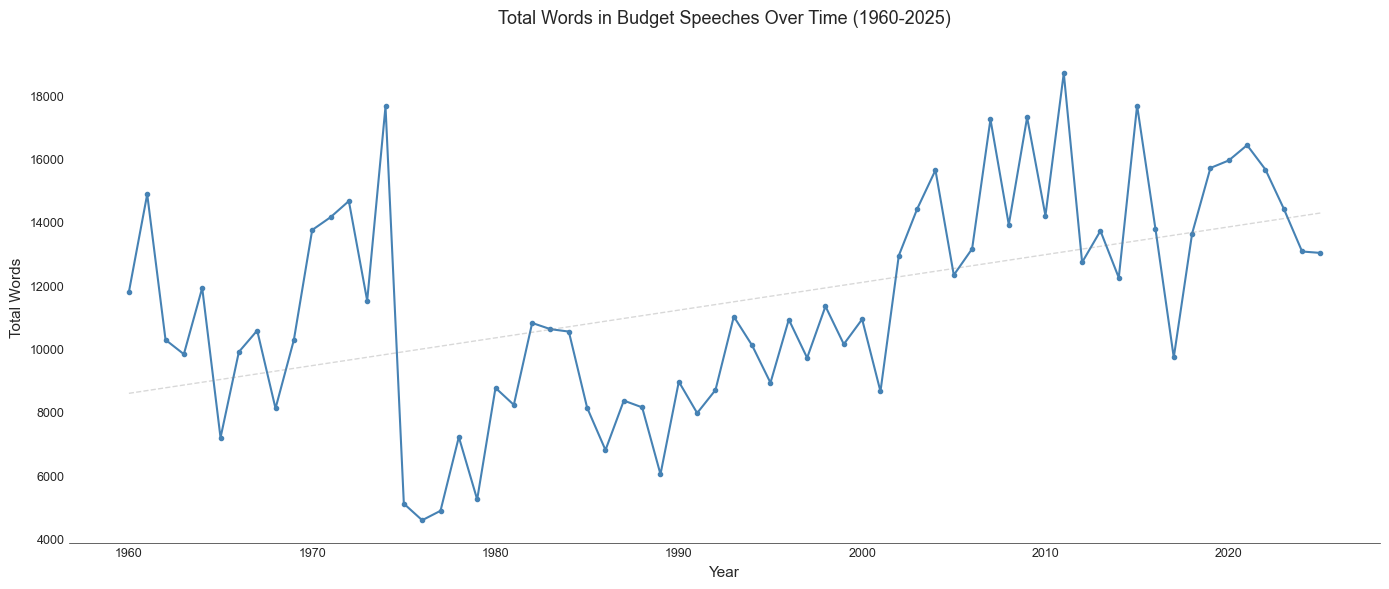

Trend: Increasing by approximately 87.6 words per year


In [7]:
# Plot total words over time
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(yearly_stats.index, yearly_stats['total_words'], marker='o', linewidth=1.5, markersize=3, color='steelblue')
ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Total Words', fontsize=11)
ax.set_title('Total Words in Budget Speeches Over Time (1960-2025)', fontsize=13, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=9)

# Add a subtle trend line
z = np.polyfit(yearly_stats.index, yearly_stats['total_words'], 1)
p = np.poly1d(z)
ax.plot(yearly_stats.index, p(yearly_stats.index), "--", alpha=0.3, linewidth=1, color='gray')

plt.tight_layout()
plt.show()

# Calculate and display trend
slope = z[0]
print(f"Trend: {'Increasing' if slope > 0 else 'Decreasing'} by approximately {abs(slope):.1f} words per year")

### Total Sentences per Year

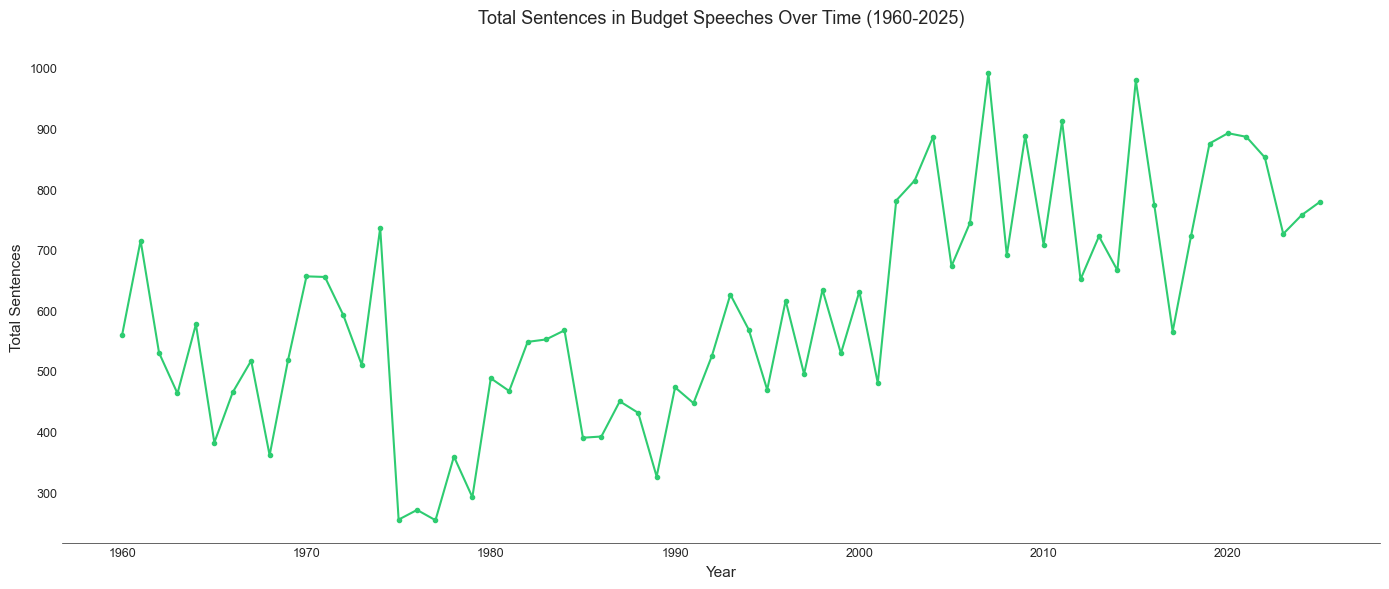

In [8]:
# Plot total sentences over time
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(yearly_stats.index, yearly_stats['total_sentences'], marker='o', linewidth=1.5, markersize=3, color='#2ecc71')
ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Total Sentences', fontsize=11)
ax.set_title('Total Sentences in Budget Speeches Over Time (1960-2025)', fontsize=13, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=9)


plt.tight_layout()
plt.show()

### Speech Characteristics by Minister

Average Speech Statistics by Minister:
                        total_words  total_sentences  avg_words_per_sentence
minister                                                                    
Tharman Shanmugaratnam      15300.3            800.9                    19.2
Heng Swee Keat              14200.8            785.8                    18.0
Lawrence Wong               14040.2            778.5                    18.1
Lee Hsien Loong             13690.4            779.6                    17.6
Goh Keng Swee               10887.3            529.1                    20.6
Lim Kim San                 10232.0            491.0                    20.9
Dr Tony Tan Keng Yam        10022.0            514.2                    19.6
Hon Sui Sen                  9966.5            454.0                    21.1
Dr Richard Hu Tsu Tau        9164.8            505.8                    18.2
Goh Chok Tong                7405.3            415.7                    17.8


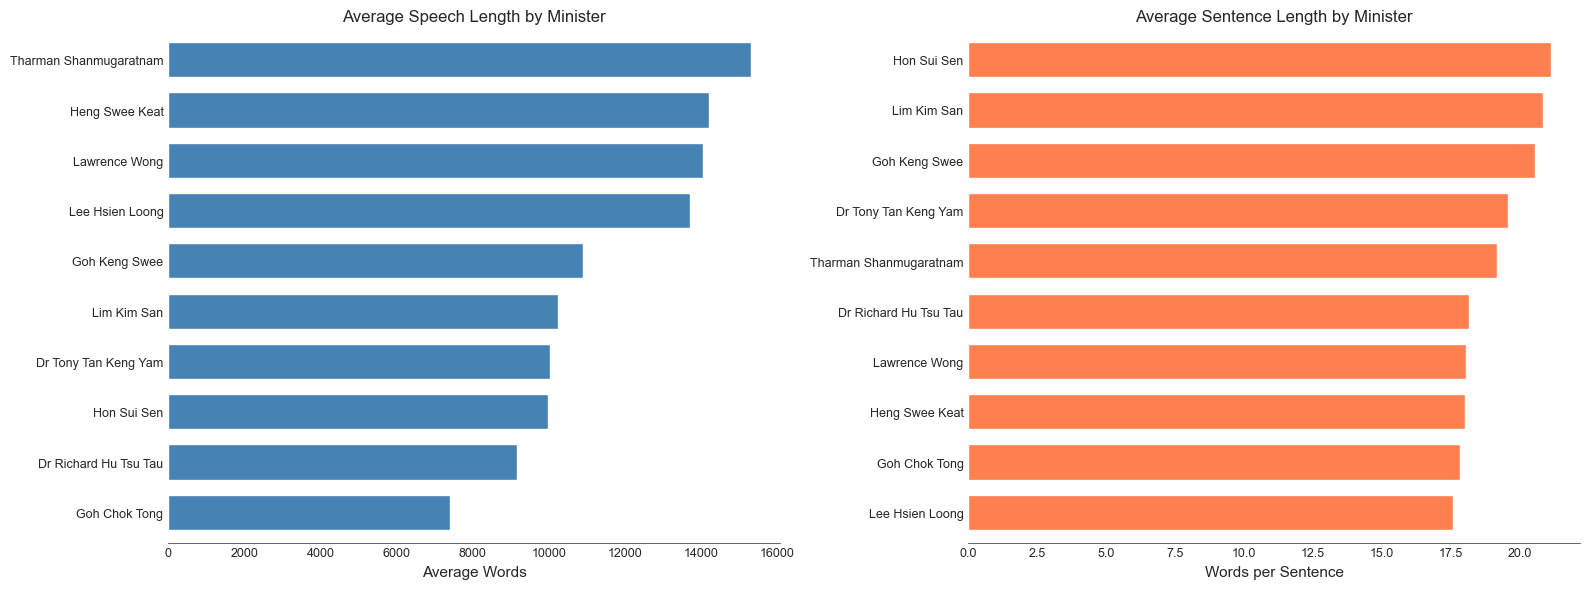

In [9]:
# Calculate average statistics by minister
minister_stats = yearly_stats.groupby('minister').agg({
    'total_words': 'mean',
    'total_sentences': 'mean',
    'avg_words_per_sentence': 'mean'
}).sort_values('total_words', ascending=False)

print("Average Speech Statistics by Minister:")
print(minister_stats.round(1))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Average total words (descending)
minister_stats['total_words'].sort_values(ascending=True).plot(kind='barh', ax=ax1, color='steelblue', width=0.7)
ax1.set_xlabel('Average Words', fontsize=11)
ax1.set_ylabel('')
ax1.set_title('Average Speech Length by Minister', fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='x', labelsize=9)
ax1.tick_params(axis='y', labelsize=9)

# Average words per sentence (descending)
minister_stats['avg_words_per_sentence'].sort_values(ascending=True).plot(kind='barh', ax=ax2, color='coral', width=0.7)
ax2.set_xlabel('Words per Sentence', fontsize=11)
ax2.set_ylabel('')
ax2.set_title('Average Sentence Length by Minister', fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='x', labelsize=9)
ax2.tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()

### Speech Length Over Time by Minister

Visualize how speech length has evolved over time, colored by minister.

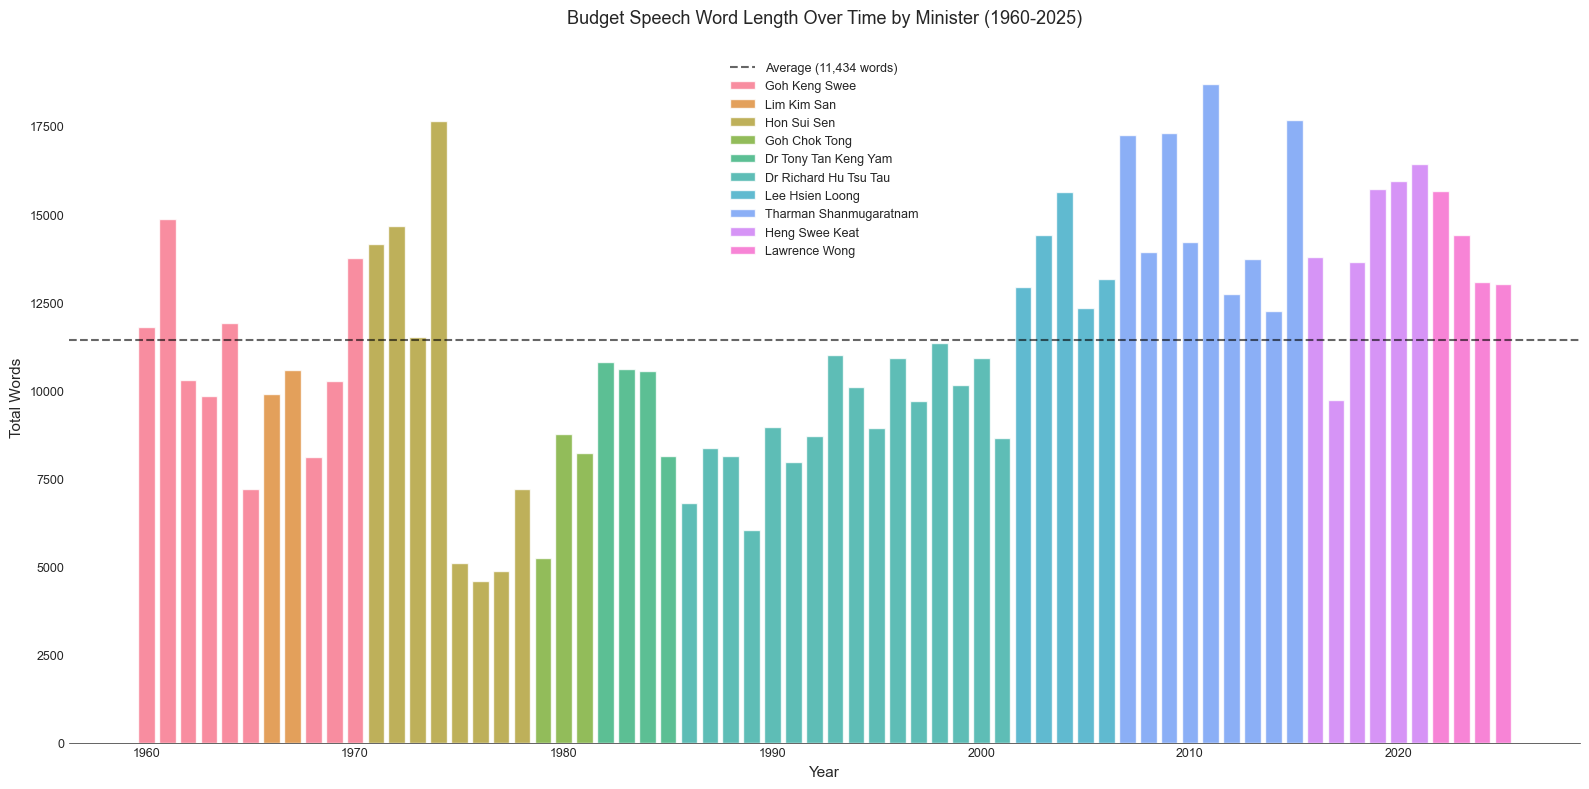

In [10]:
# Plot speech length colored by minister
fig, ax = plt.subplots(figsize=(16, 8))

# Get unique ministers and assign colors
ministers = yearly_stats['minister'].unique()
colors = sns.color_palette('husl', n_colors=len(ministers))
minister_colors = dict(zip(ministers, colors))

# Plot each minister with different color
for minister in ministers:
    minister_data = yearly_stats[yearly_stats['minister'] == minister]
    ax.bar(minister_data.index, minister_data['total_words'], 
           label=minister, color=minister_colors[minister], alpha=0.8)

# Add average line
avg_words = yearly_stats['total_words'].mean()
ax.axhline(y=avg_words, color='black', linestyle='--', linewidth=1.5, 
           label=f'Average ({avg_words:,.0f} words)', alpha=0.6)

ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Total Words', fontsize=11)
ax.set_title('Budget Speech Word Length Over Time by Minister (1960-2025)', fontsize=13, pad=20)
ax.legend(loc='best', frameon=False, fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

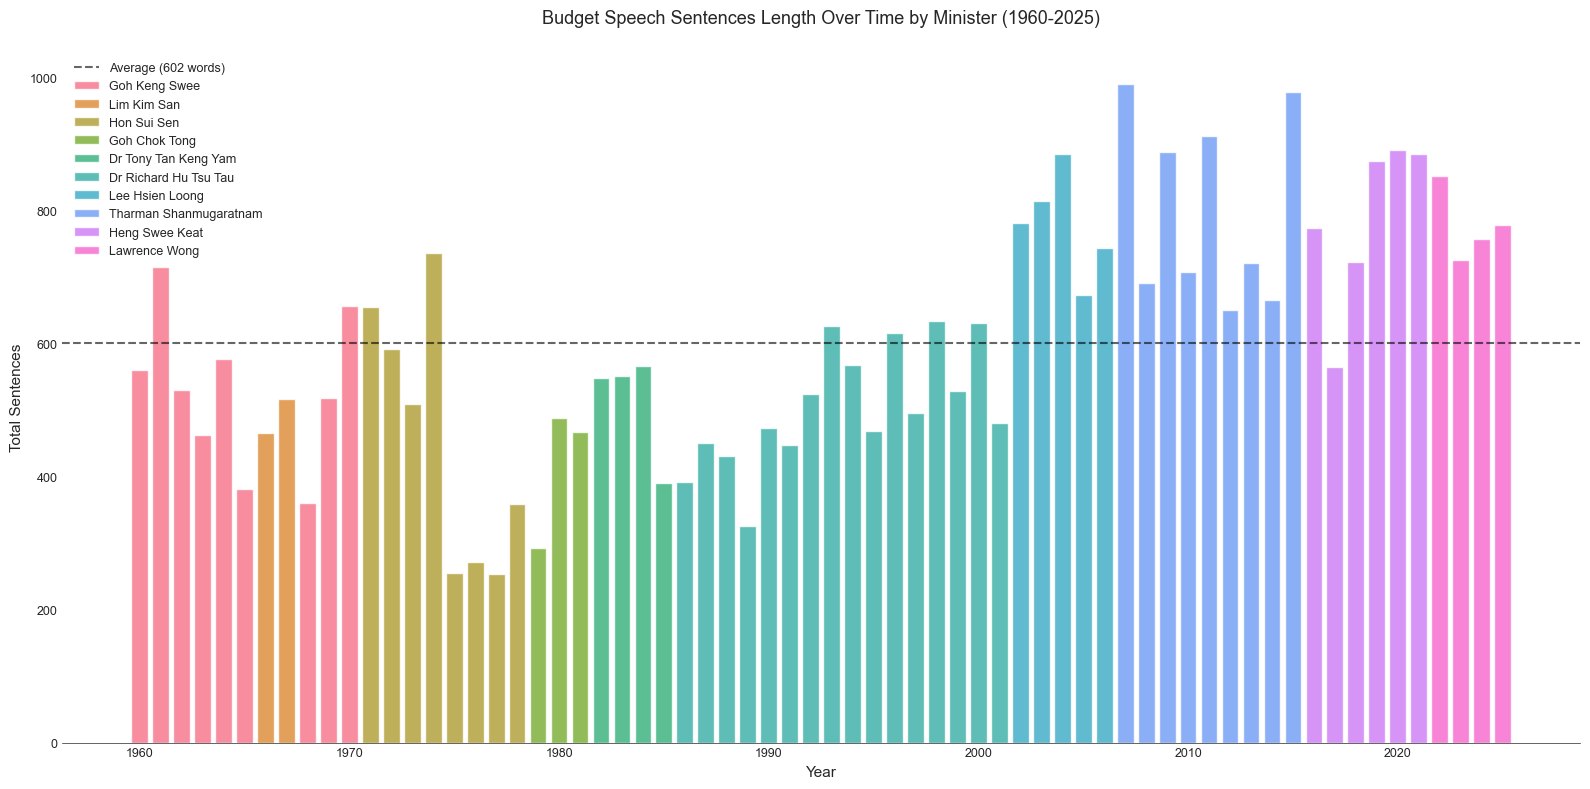

In [11]:
# Plot speech length colored by minister
fig, ax = plt.subplots(figsize=(16, 8))

# Get unique ministers and assign colors
ministers = yearly_stats['minister'].unique()
colors = sns.color_palette('husl', n_colors=len(ministers))
minister_colors = dict(zip(ministers, colors))

# Plot each minister with different color
for minister in ministers:
    minister_data = yearly_stats[yearly_stats['minister'] == minister]
    ax.bar(minister_data.index, minister_data['total_sentences'], 
           label=minister, color=minister_colors[minister], alpha=0.8)

# Add average line
avg_words = yearly_stats['total_sentences'].mean()
ax.axhline(y=avg_words, color='black', linestyle='--', linewidth=1.5, 
           label=f'Average ({avg_words:,.0f} words)', alpha=0.6)

ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Total Sentences', fontsize=11)
ax.set_title('Budget Speech Sentences Length Over Time by Minister (1960-2025)', fontsize=13, pad=20)
ax.legend(loc='best', frameon=False, fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

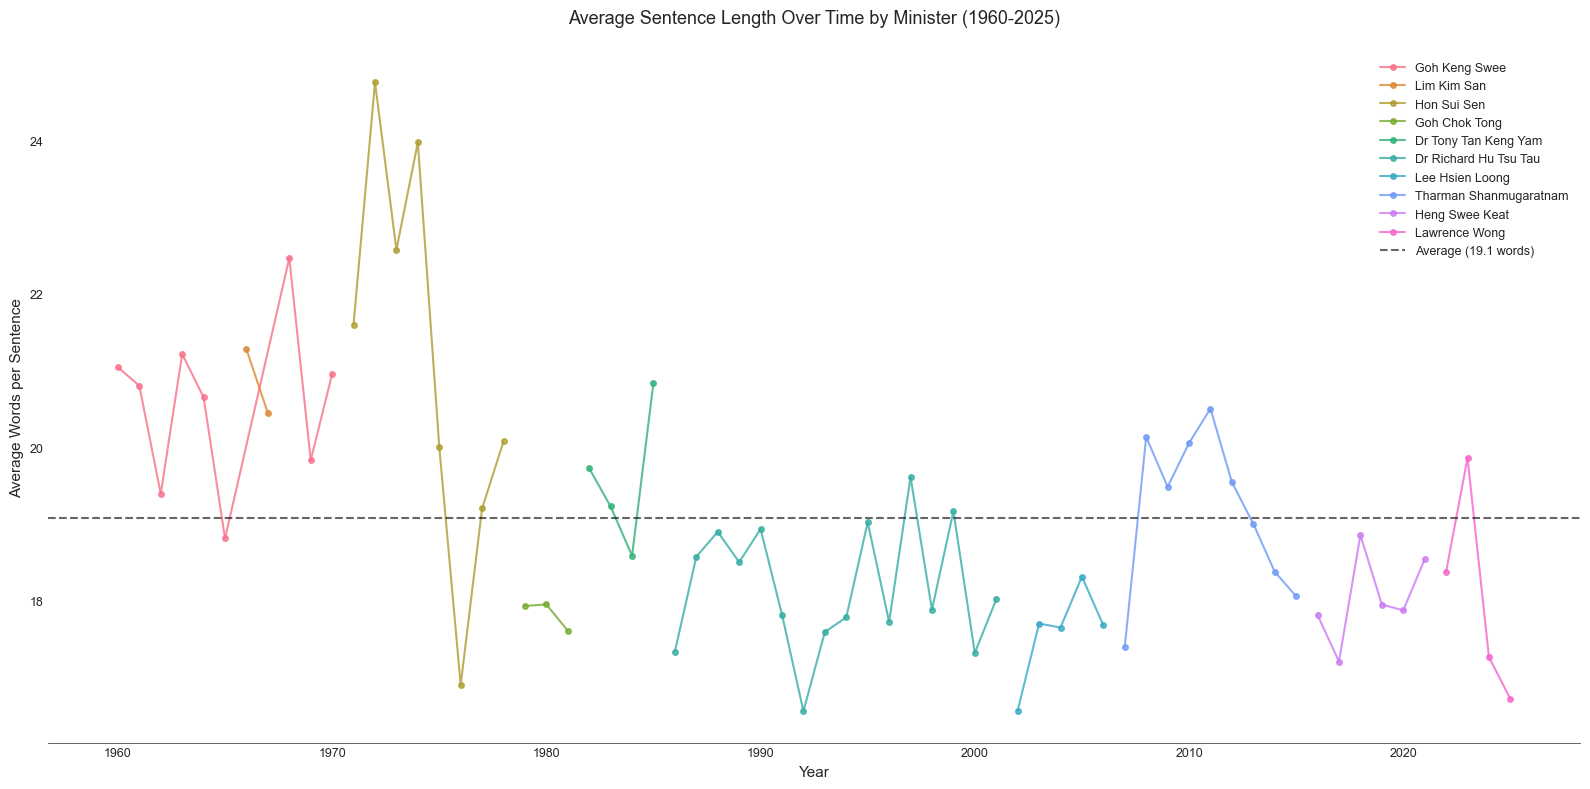

In [12]:
# Plot average sentence length colored by minister
fig, ax = plt.subplots(figsize=(16, 8))

# Get unique ministers and assign colors
ministers = yearly_stats['minister'].unique()
colors = sns.color_palette('husl', n_colors=len(ministers))
minister_colors = dict(zip(ministers, colors))

# Plot each minister with different color
for minister in ministers:
    minister_data = yearly_stats[yearly_stats['minister'] == minister]
    ax.plot(minister_data.index, minister_data['avg_words_per_sentence'], 
            marker='o', linewidth=1.5, markersize=4, 
            label=minister, color=minister_colors[minister], alpha=0.8)

# Add average line
avg_sentence_length = yearly_stats['avg_words_per_sentence'].mean()
ax.axhline(y=avg_sentence_length, color='black', linestyle='--', linewidth=1.5, 
           label=f'Average ({avg_sentence_length:.1f} words)', alpha=0.6)

ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Average Words per Sentence', fontsize=11)
ax.set_title('Average Sentence Length Over Time by Minister (1960-2025)', fontsize=13, pad=20)
ax.legend(loc='best', frameon=False, fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

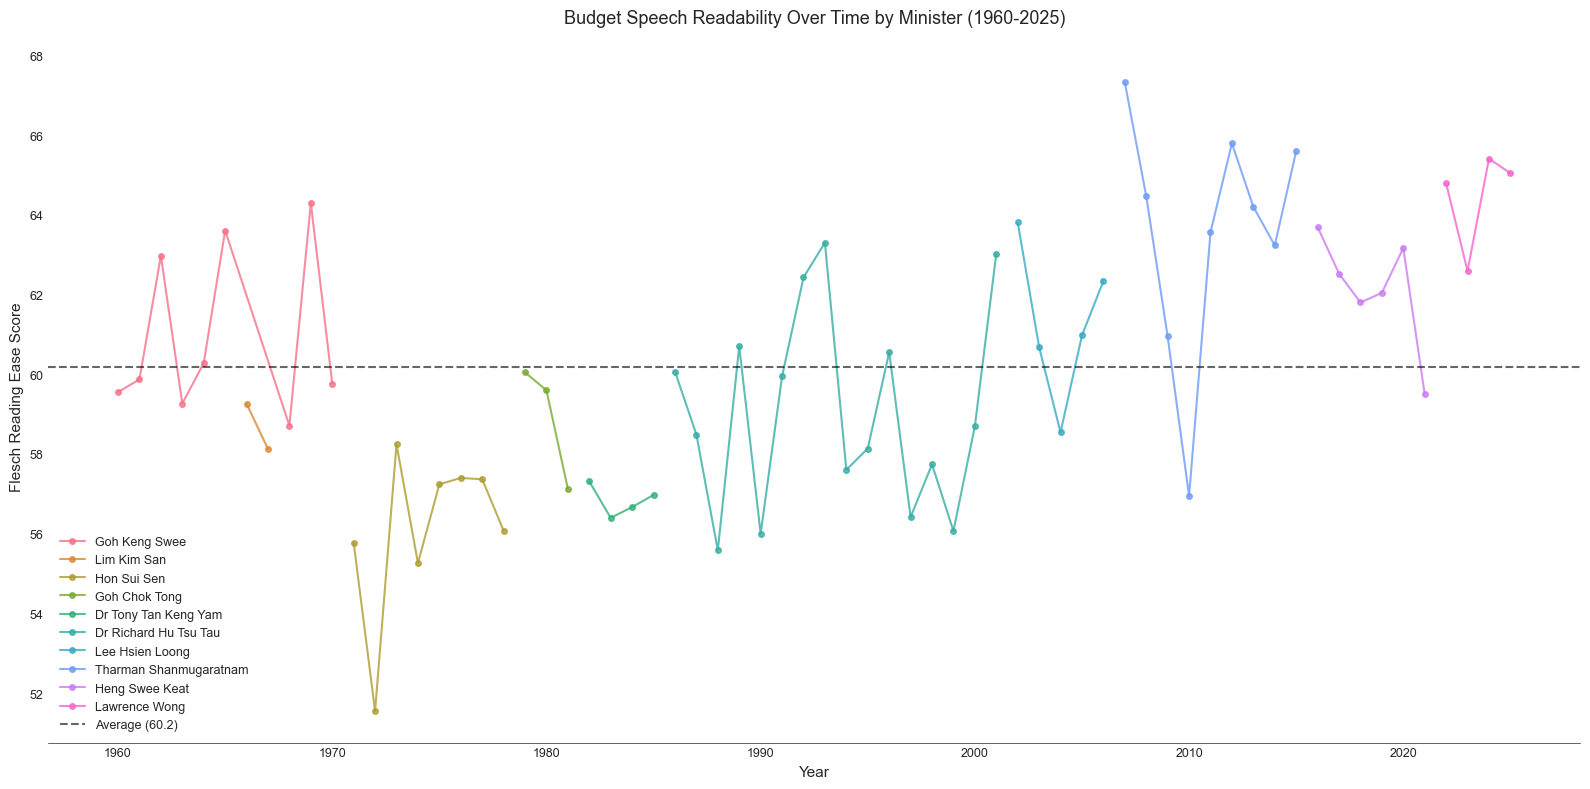


Readability Scale (Flesch Reading Ease):
90-100: Very Easy (5th grade)
80-89:  Easy (6th grade)
70-79:  Fairly Easy (7th grade)
60-69:  Standard (8th-9th grade)
50-59:  Fairly Difficult (10th-12th grade)
30-49:  Difficult (College)
0-29:   Very Difficult (College graduate)


In [13]:
# Calculate Flesch Reading Ease for each year
def calculate_flesch_reading_ease(total_words, total_sentences, total_syllables):
    """
    Flesch Reading Ease = 206.835 - 1.015 * (words/sentences) - 84.6 * (syllables/words)
    Higher scores = easier to read
    """
    if total_sentences == 0 or total_words == 0:
        return 0
    asl = total_words / total_sentences  # Average Sentence Length
    asw = total_syllables / total_words  # Average Syllables per Word
    return 206.835 - (1.015 * asl) - (84.6 * asw)

# Calculate total syllables for each year
yearly_syllables = df_all.groupby('year')['syllable_count'].sum()
yearly_stats['total_syllables'] = yearly_syllables

# Calculate Flesch Reading Ease
yearly_stats['readability'] = yearly_stats.apply(
    lambda row: calculate_flesch_reading_ease(
        row['total_words'], 
        row['total_sentences'], 
        row['total_syllables']
    ), axis=1
)

# Plot readability colored by minister
fig, ax = plt.subplots(figsize=(16, 8))

# Get unique ministers and assign colors
ministers = yearly_stats['minister'].unique()
colors = sns.color_palette('husl', n_colors=len(ministers))
minister_colors = dict(zip(ministers, colors))

# Plot each minister with different color
for minister in ministers:
    minister_data = yearly_stats[yearly_stats['minister'] == minister]
    ax.plot(minister_data.index, minister_data['readability'], 
            marker='o', linewidth=1.5, markersize=4, 
            label=minister, color=minister_colors[minister], alpha=0.8)

# Add average line
avg_readability = yearly_stats['readability'].mean()
ax.axhline(y=avg_readability, color='black', linestyle='--', linewidth=1.5, 
           label=f'Average ({avg_readability:.1f})', alpha=0.6)

ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Flesch Reading Ease Score', fontsize=11)
ax.set_title('Budget Speech Readability Over Time by Minister (1960-2025)', fontsize=13, pad=20)
ax.legend(loc='best', frameon=False, fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

print("\nReadability Scale (Flesch Reading Ease):")
print("90-100: Very Easy (5th grade)")
print("80-89:  Easy (6th grade)")
print("70-79:  Fairly Easy (7th grade)")
print("60-69:  Standard (8th-9th grade)")
print("50-59:  Fairly Difficult (10th-12th grade)")
print("30-49:  Difficult (College)")
print("0-29:   Very Difficult (College graduate)")

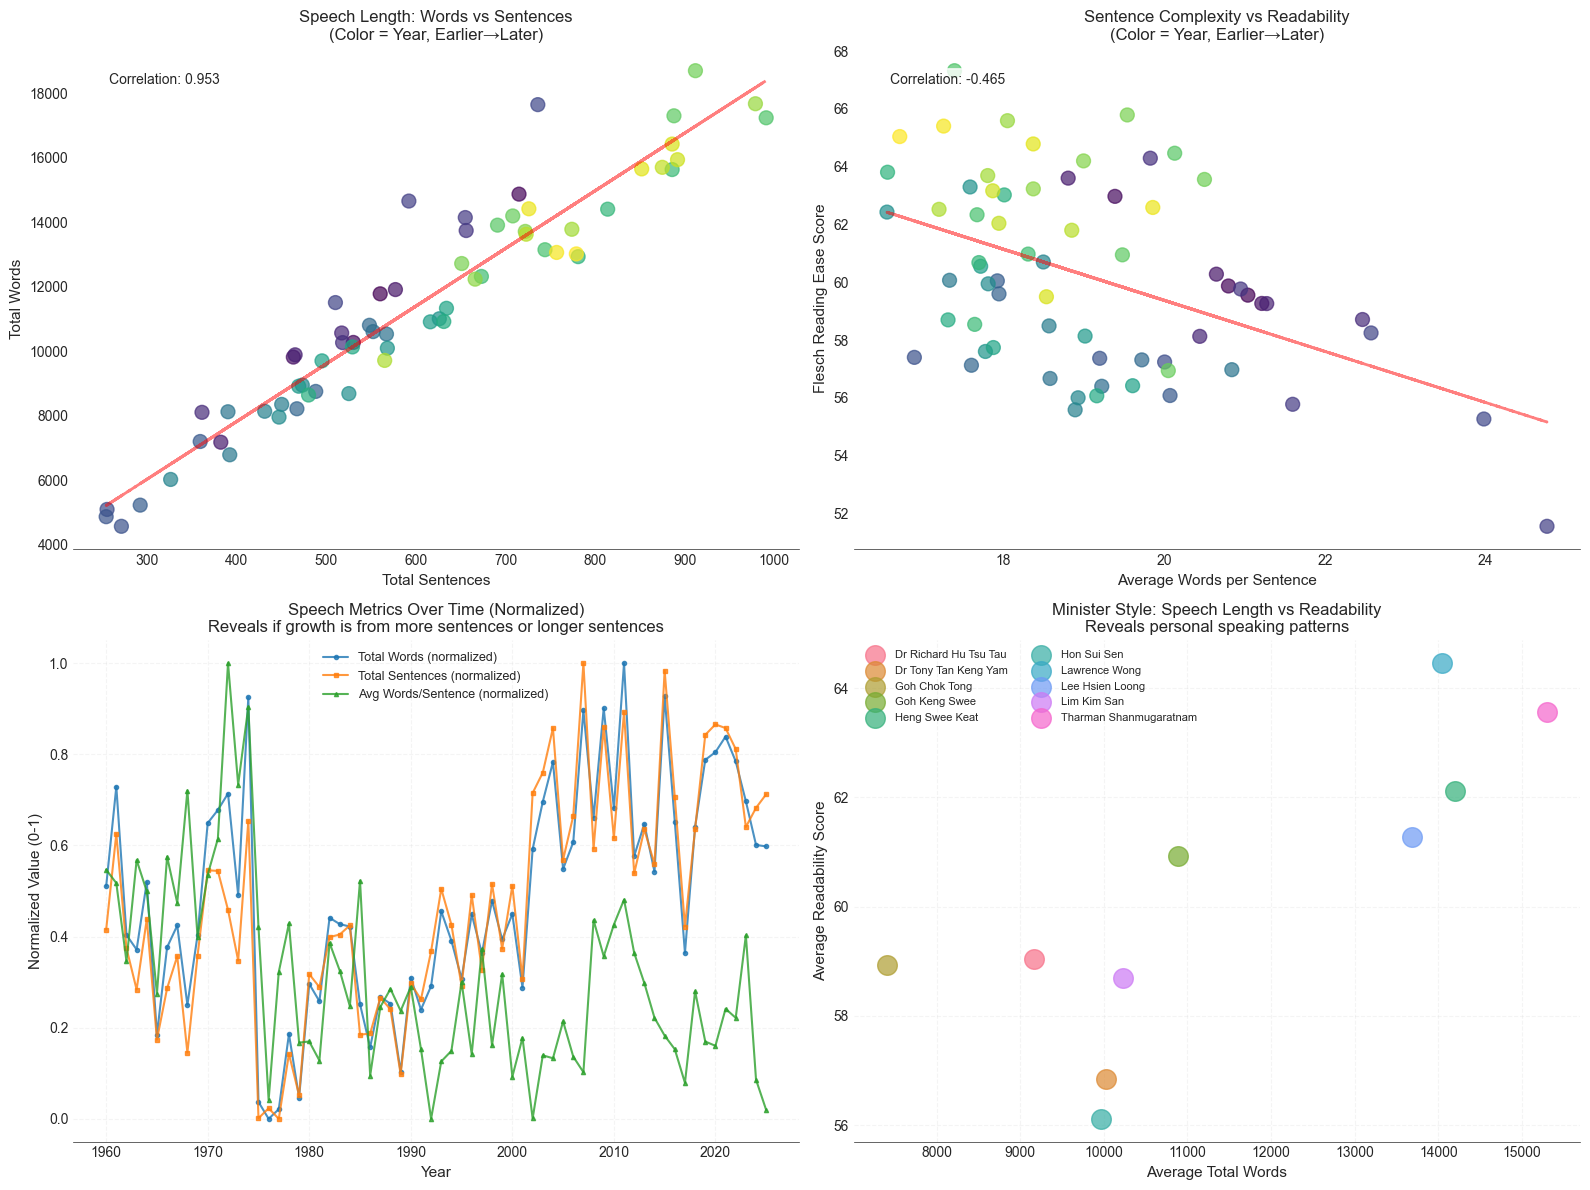


KEY INSIGHTS FROM DECOMPOSITION ANALYSIS

1. SPEECH LENGTH DRIVERS:
   - Correlation between sentences and words: 0.953
   - When this is close to 1.0, speeches grow by adding MORE sentences
   - When slope changes, it means sentence LENGTH is changing

2. READABILITY FACTORS:
   - Correlation between sentence length and readability: -0.465
   - Negative correlation means: longer sentences = harder to read

3. TEMPORAL TRENDS:
   - Words/year change: +87.6 words/year
   - Sentences/year change: +6.21 sentences/year
   - Avg words per sentence change: -0.047 words/year

4. MINISTER PATTERNS:
   - Most verbose: Tharman Shanmugaratnam (15300 words avg)
   - Most concise: Goh Chok Tong (7405 words avg)
   - Most readable: Lawrence Wong (64.5 score)
   - Most complex: Hon Sui Sen (56.1 score)


In [14]:
# Decomposition Analysis: Understanding the Phenomena
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Relationship: Total Words vs Total Sentences (Are speeches getting longer with more sentences or longer sentences?)
ax1.scatter(yearly_stats['total_sentences'], yearly_stats['total_words'], 
           c=yearly_stats.index, cmap='viridis', s=100, alpha=0.7)
ax1.set_xlabel('Total Sentences', fontsize=11)
ax1.set_ylabel('Total Words', fontsize=11)
ax1.set_title('Speech Length: Words vs Sentences\n(Color = Year, Earlier→Later)', fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add correlation line
z1 = np.polyfit(yearly_stats['total_sentences'], yearly_stats['total_words'], 1)
p1 = np.poly1d(z1)
ax1.plot(yearly_stats['total_sentences'], p1(yearly_stats['total_sentences']), 
         "--", alpha=0.5, color='red', linewidth=2)
corr1 = yearly_stats['total_sentences'].corr(yearly_stats['total_words'])
ax1.text(0.05, 0.95, f'Correlation: {corr1:.3f}', transform=ax1.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Relationship: Avg Words per Sentence vs Readability (Does complexity affect readability?)
ax2.scatter(yearly_stats['avg_words_per_sentence'], yearly_stats['readability'], 
           c=yearly_stats.index, cmap='viridis', s=100, alpha=0.7)
ax2.set_xlabel('Average Words per Sentence', fontsize=11)
ax2.set_ylabel('Flesch Reading Ease Score', fontsize=11)
ax2.set_title('Sentence Complexity vs Readability\n(Color = Year, Earlier→Later)', fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add correlation line
z2 = np.polyfit(yearly_stats['avg_words_per_sentence'], yearly_stats['readability'], 1)
p2 = np.poly1d(z2)
ax2.plot(yearly_stats['avg_words_per_sentence'], p2(yearly_stats['avg_words_per_sentence']), 
         "--", alpha=0.5, color='red', linewidth=2)
corr2 = yearly_stats['avg_words_per_sentence'].corr(yearly_stats['readability'])
ax2.text(0.05, 0.95, f'Correlation: {corr2:.3f}', transform=ax2.transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Triple metric over time: Normalized view
# Normalize all metrics to 0-1 scale for comparison
norm_words = (yearly_stats['total_words'] - yearly_stats['total_words'].min()) / (yearly_stats['total_words'].max() - yearly_stats['total_words'].min())
norm_sentences = (yearly_stats['total_sentences'] - yearly_stats['total_sentences'].min()) / (yearly_stats['total_sentences'].max() - yearly_stats['total_sentences'].min())
norm_avg_words = (yearly_stats['avg_words_per_sentence'] - yearly_stats['avg_words_per_sentence'].min()) / (yearly_stats['avg_words_per_sentence'].max() - yearly_stats['avg_words_per_sentence'].min())

ax3.plot(yearly_stats.index, norm_words, marker='o', markersize=3, linewidth=1.5, label='Total Words (normalized)', alpha=0.8)
ax3.plot(yearly_stats.index, norm_sentences, marker='s', markersize=3, linewidth=1.5, label='Total Sentences (normalized)', alpha=0.8)
ax3.plot(yearly_stats.index, norm_avg_words, marker='^', markersize=3, linewidth=1.5, label='Avg Words/Sentence (normalized)', alpha=0.8)
ax3.set_xlabel('Year', fontsize=11)
ax3.set_ylabel('Normalized Value (0-1)', fontsize=11)
ax3.set_title('Speech Metrics Over Time (Normalized)\nReveals if growth is from more sentences or longer sentences', fontsize=12)
ax3.legend(loc='best', frameon=False, fontsize=9)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.grid(True, alpha=0.2, linestyle='--')

# 4. Minister comparison: Readability vs Speech Length
minister_avg = yearly_stats.groupby('minister').agg({
    'total_words': 'mean',
    'readability': 'mean',
    'avg_words_per_sentence': 'mean'
})

colors_minister = sns.color_palette('husl', n_colors=len(minister_avg))
for i, (minister, row) in enumerate(minister_avg.iterrows()):
    ax4.scatter(row['total_words'], row['readability'], 
               s=200, alpha=0.7, color=colors_minister[i], label=minister)
    
ax4.set_xlabel('Average Total Words', fontsize=11)
ax4.set_ylabel('Average Readability Score', fontsize=11)
ax4.set_title('Minister Style: Speech Length vs Readability\nReveals personal speaking patterns', fontsize=12)
ax4.legend(loc='best', frameon=False, fontsize=8, ncol=2)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.show()

# Print key insights
print("\n" + "="*80)
print("KEY INSIGHTS FROM DECOMPOSITION ANALYSIS")
print("="*80)
print(f"\n1. SPEECH LENGTH DRIVERS:")
print(f"   - Correlation between sentences and words: {corr1:.3f}")
print(f"   - When this is close to 1.0, speeches grow by adding MORE sentences")
print(f"   - When slope changes, it means sentence LENGTH is changing")

print(f"\n2. READABILITY FACTORS:")
print(f"   - Correlation between sentence length and readability: {corr2:.3f}")
print(f"   - Negative correlation means: longer sentences = harder to read")

print(f"\n3. TEMPORAL TRENDS:")
words_trend = np.polyfit(yearly_stats.index, yearly_stats['total_words'], 1)[0]
sentences_trend = np.polyfit(yearly_stats.index, yearly_stats['total_sentences'], 1)[0]
avg_words_trend = np.polyfit(yearly_stats.index, yearly_stats['avg_words_per_sentence'], 1)[0]
print(f"   - Words/year change: {words_trend:+.1f} words/year")
print(f"   - Sentences/year change: {sentences_trend:+.2f} sentences/year")
print(f"   - Avg words per sentence change: {avg_words_trend:+.3f} words/year")

print(f"\n4. MINISTER PATTERNS:")
print(f"   - Most verbose: {minister_avg['total_words'].idxmax()} ({minister_avg['total_words'].max():.0f} words avg)")
print(f"   - Most concise: {minister_avg['total_words'].idxmin()} ({minister_avg['total_words'].min():.0f} words avg)")
print(f"   - Most readable: {minister_avg['readability'].idxmax()} ({minister_avg['readability'].max():.1f} score)")
print(f"   - Most complex: {minister_avg['readability'].idxmin()} ({minister_avg['readability'].min():.1f} score)")

## Cluster Analysis: Identifying Speech Patterns

Perform clustering analysis to identify distinct patterns in speech characteristics and see how ministers group together.

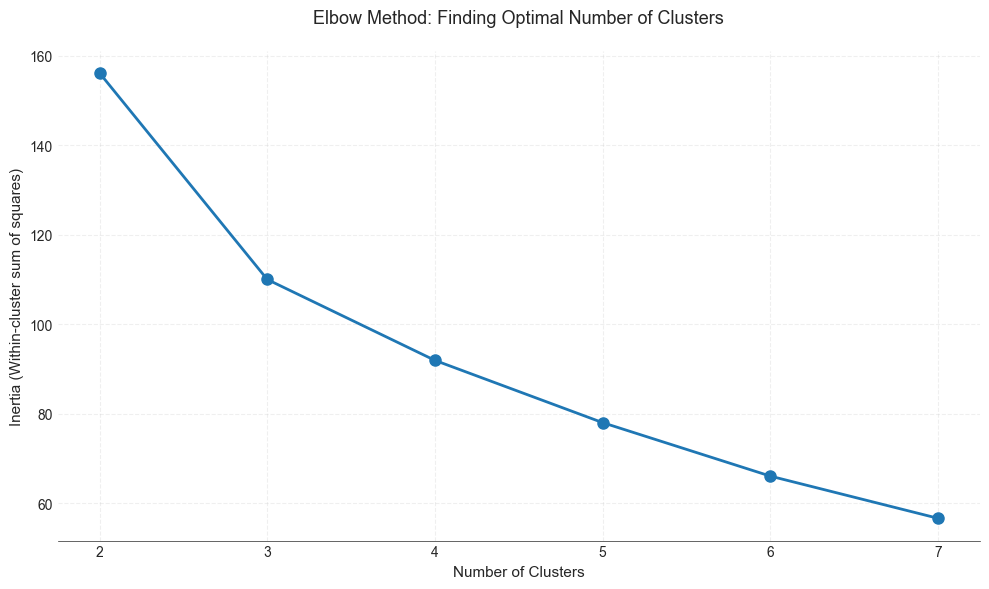

Inertia values for different k:
  k=2: 156.17
  k=3: 110.02
  k=4: 91.93
  k=5: 78.01
  k=6: 66.06
  k=7: 56.62


In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Prepare features for clustering
features_for_clustering = yearly_stats[[
    'total_words', 
    'total_sentences', 
    'avg_words_per_sentence', 
    'readability'
]].copy()

# Handle any missing values
features_for_clustering = features_for_clustering.fillna(features_for_clustering.mean())

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 8)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(features_scaled)
    inertias.append(kmeans_temp.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters', fontsize=11)
ax.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=11)
ax.set_title('Elbow Method: Finding Optimal Number of Clusters', fontsize=13, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("Inertia values for different k:")
for k, inertia in zip(K_range, inertias):
    print(f"  k={k}: {inertia:.2f}")

/var/folders/fp/v2xmk7y916s5yhfs6dqmdz3w0000gn/T/ipykernel_24238/3517838370.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(cluster_data, labels=[f'Cluster {i}' for i in range(optimal_k)],
/var/folders/fp/v2xmk7y916s5yhfs6dqmdz3w0000gn/T/ipykernel_24238/3517838370.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax3.boxplot(cluster_readability, labels=[f'Cluster {i}' for i in range(optimal_k)],


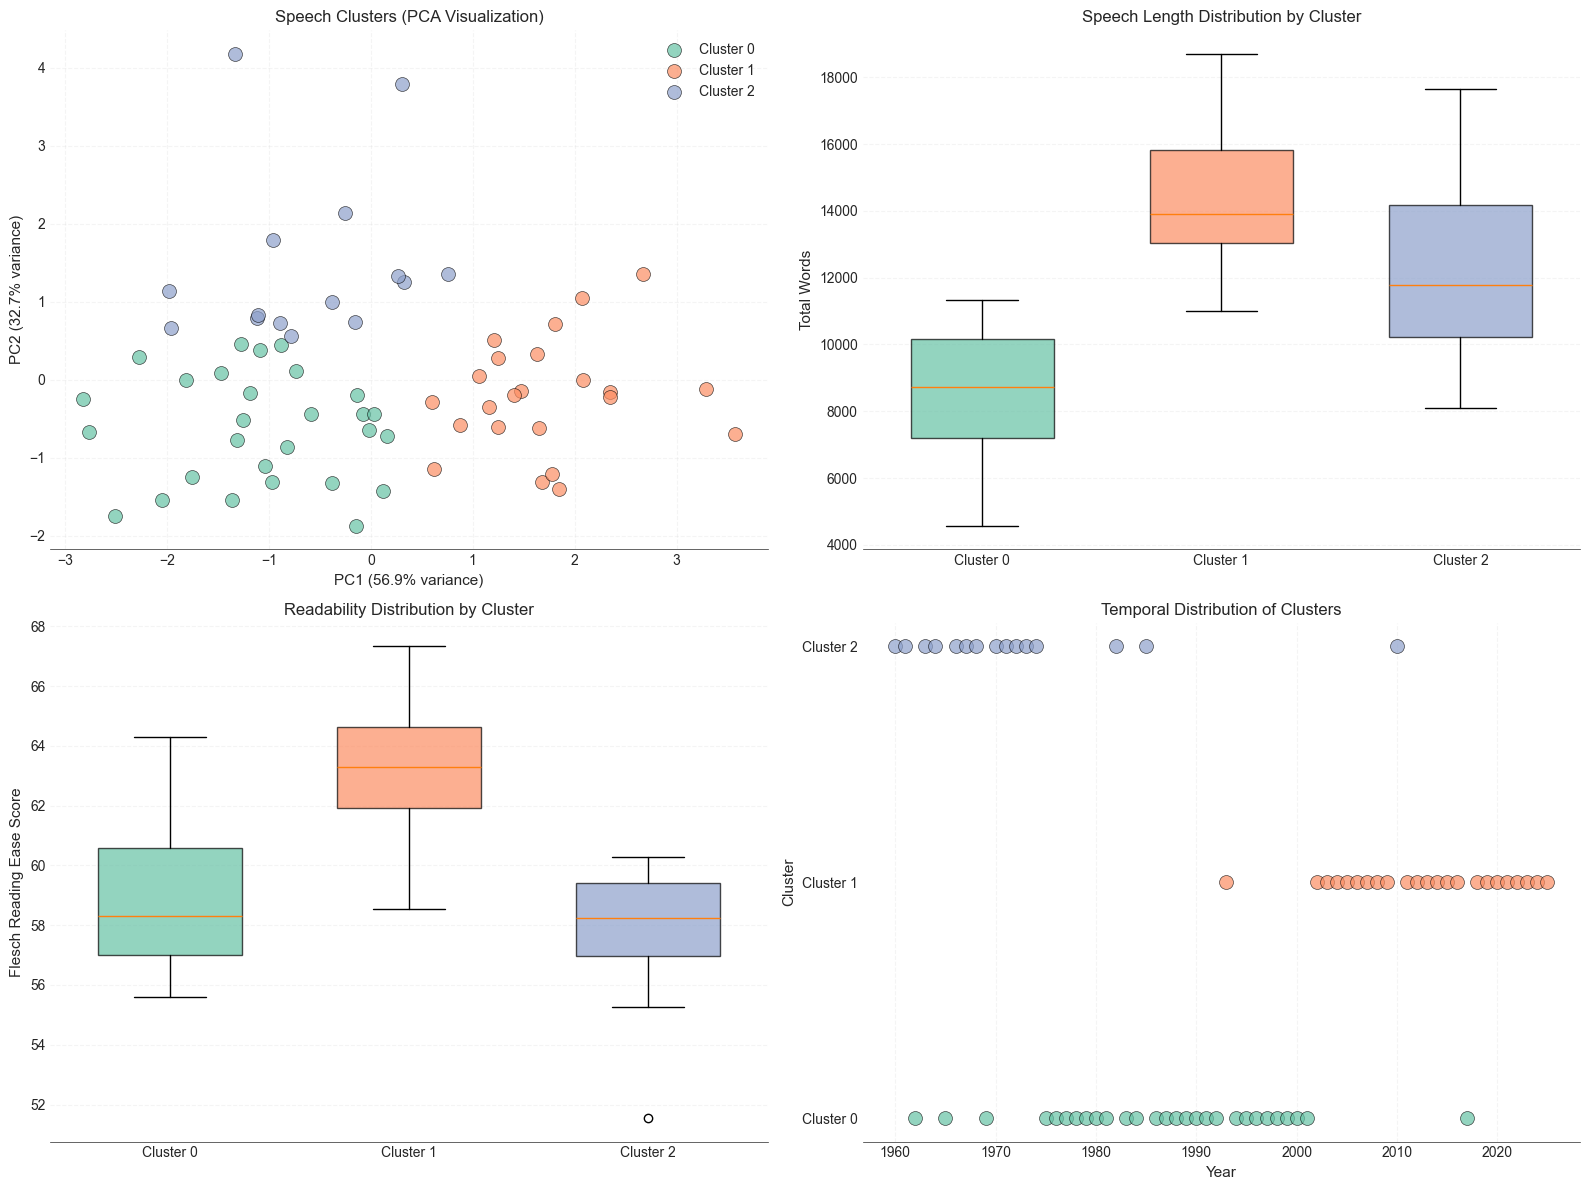


CLUSTER CHARACTERISTICS

Cluster 0 (28 speeches):
  Avg total words: 8,508 (±1991)
  Avg readability: 59.0 (±2.6)
  Avg words/sentence: 18.4 (±1.0)
  Year range: 1962 - 2017

Cluster 1 (23 speeches):
  Avg total words: 14,548 (±2009)
  Avg readability: 63.2 (±2.1)
  Avg words/sentence: 18.3 (±1.0)
  Year range: 1993 - 2025

Cluster 2 (15 speeches):
  Avg total words: 12,121 (±2706)
  Avg readability: 57.8 (±2.3)
  Avg words/sentence: 21.5 (±1.4)
  Year range: 1960 - 2010


In [16]:
# Perform clustering with optimal k (choosing k=3 based on elbow method)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
yearly_stats['cluster'] = kmeans.fit_predict(features_scaled)

# Perform PCA for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Visualize clusters
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. PCA visualization colored by cluster
cluster_colors = sns.color_palette('Set2', n_colors=optimal_k)
for cluster in range(optimal_k):
    mask = yearly_stats['cluster'] == cluster
    ax1.scatter(features_pca[mask, 0], features_pca[mask, 1], 
               c=[cluster_colors[cluster]], s=100, alpha=0.7, 
               label=f'Cluster {cluster}', edgecolors='black', linewidth=0.5)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_title('Speech Clusters (PCA Visualization)', fontsize=12)
ax1.legend(frameon=False, fontsize=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(True, alpha=0.2, linestyle='--')

# 2. Cluster characteristics - box plots
cluster_data = []
for cluster in range(optimal_k):
    cluster_mask = yearly_stats['cluster'] == cluster
    cluster_data.append(yearly_stats[cluster_mask]['total_words'])

bp = ax2.boxplot(cluster_data, labels=[f'Cluster {i}' for i in range(optimal_k)],
                  patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], cluster_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Total Words', fontsize=11)
ax2.set_title('Speech Length Distribution by Cluster', fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True, alpha=0.2, linestyle='--', axis='y')

# 3. Readability by cluster
cluster_readability = []
for cluster in range(optimal_k):
    cluster_mask = yearly_stats['cluster'] == cluster
    cluster_readability.append(yearly_stats[cluster_mask]['readability'])

bp2 = ax3.boxplot(cluster_readability, labels=[f'Cluster {i}' for i in range(optimal_k)],
                   patch_artist=True, widths=0.6)
for patch, color in zip(bp2['boxes'], cluster_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_ylabel('Flesch Reading Ease Score', fontsize=11)
ax3.set_title('Readability Distribution by Cluster', fontsize=12)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.grid(True, alpha=0.2, linestyle='--', axis='y')

# 4. Temporal distribution of clusters
for cluster in range(optimal_k):
    cluster_mask = yearly_stats['cluster'] == cluster
    cluster_years = yearly_stats[cluster_mask].index
    ax4.scatter(cluster_years, [cluster] * len(cluster_years), 
               c=[cluster_colors[cluster]], s=100, alpha=0.7, 
               label=f'Cluster {cluster}', edgecolors='black', linewidth=0.5)

ax4.set_xlabel('Year', fontsize=11)
ax4.set_ylabel('Cluster', fontsize=11)
ax4.set_title('Temporal Distribution of Clusters', fontsize=12)
ax4.set_yticks(range(optimal_k))
ax4.set_yticklabels([f'Cluster {i}' for i in range(optimal_k)])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.grid(True, alpha=0.2, linestyle='--', axis='x')

plt.tight_layout()
plt.show()

# Print cluster statistics
print("\n" + "="*80)
print("CLUSTER CHARACTERISTICS")
print("="*80)
for cluster in range(optimal_k):
    cluster_mask = yearly_stats['cluster'] == cluster
    cluster_speeches = yearly_stats[cluster_mask]
    print(f"\nCluster {cluster} ({len(cluster_speeches)} speeches):")
    print(f"  Avg total words: {cluster_speeches['total_words'].mean():,.0f} (±{cluster_speeches['total_words'].std():.0f})")
    print(f"  Avg readability: {cluster_speeches['readability'].mean():.1f} (±{cluster_speeches['readability'].std():.1f})")
    print(f"  Avg words/sentence: {cluster_speeches['avg_words_per_sentence'].mean():.1f} (±{cluster_speeches['avg_words_per_sentence'].std():.1f})")
    print(f"  Year range: {cluster_speeches.index.min()} - {cluster_speeches.index.max()}")


MINISTER EVOLUTION: CLUSTER TRANSITIONS OVER TIME

Goh Keng Swee (1960-1970):
  Style evolved across 2 clusters:
    1960-1961: Cluster 2
    1962-1962: Cluster 0
    1963-1964: Cluster 2
    1965-1965: Cluster 0
    1968-1968: Cluster 2
    1969-1969: Cluster 0
    1970-1970: Cluster 2

Lim Kim San (1966-1967):
  Consistent style: All speeches in Cluster 2

Hon Sui Sen (1971-1978):
  Style evolved across 2 clusters:
    1971-1974: Cluster 2
    1975-1978: Cluster 0

Goh Chok Tong (1979-1981):
  Consistent style: All speeches in Cluster 0

Dr Tony Tan Keng Yam (1982-1985):
  Style evolved across 2 clusters:
    1982-1982: Cluster 2
    1983-1984: Cluster 0
    1985-1985: Cluster 2

Dr Richard Hu Tsu Tau (1986-2001):
  Style evolved across 2 clusters:
    1986-1992: Cluster 0
    1993-1993: Cluster 1
    1994-2001: Cluster 0

Lee Hsien Loong (2002-2006):
  Consistent style: All speeches in Cluster 1

Tharman Shanmugaratnam (2007-2015):
  Style evolved across 2 clusters:
    2007-2009: 

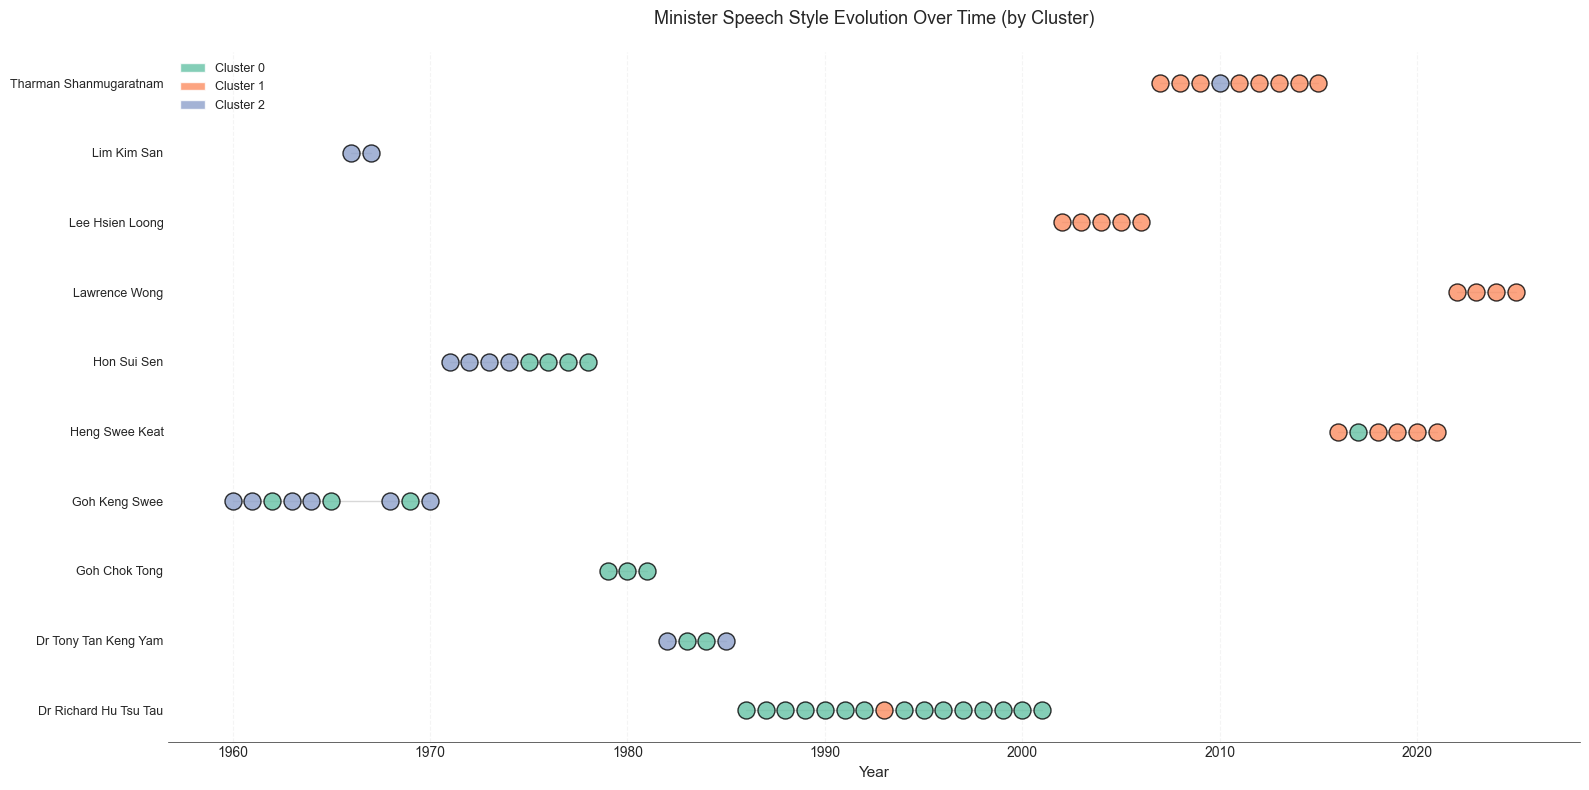

In [17]:
# Advanced analysis: Minister transitions between clusters over time
print("\n" + "="*80)
print("MINISTER EVOLUTION: CLUSTER TRANSITIONS OVER TIME")
print("="*80)

for minister in yearly_stats['minister'].unique():
    if pd.notna(minister):
        minister_data = yearly_stats[yearly_stats['minister'] == minister].sort_index()
        if len(minister_data) > 1:
            print(f"\n{minister} ({minister_data.index.min()}-{minister_data.index.max()}):")
            
            # Check if minister's style changed over time
            clusters_over_time = minister_data['cluster'].tolist()
            years = minister_data.index.tolist()
            
            # Group consecutive years by cluster
            transitions = []
            current_cluster = clusters_over_time[0]
            start_year = years[0]
            
            for i in range(1, len(clusters_over_time)):
                if clusters_over_time[i] != current_cluster:
                    transitions.append(f"    {start_year}-{years[i-1]}: Cluster {current_cluster}")
                    current_cluster = clusters_over_time[i]
                    start_year = years[i]
            
            # Add the last period
            transitions.append(f"    {start_year}-{years[-1]}: Cluster {current_cluster}")
            
            if len(set(clusters_over_time)) > 1:
                print(f"  Style evolved across {len(set(clusters_over_time))} clusters:")
                for transition in transitions:
                    print(transition)
            else:
                print(f"  Consistent style: All speeches in Cluster {clusters_over_time[0]}")

# Visualize minister evolution
fig, ax = plt.subplots(figsize=(16, 8))

ministers_with_multiple_speeches = yearly_stats.groupby('minister').size()
ministers_with_multiple_speeches = ministers_with_multiple_speeches[ministers_with_multiple_speeches > 1].index

y_pos = 0
yticks = []
yticklabels = []

for minister in ministers_with_multiple_speeches:
    minister_data = yearly_stats[yearly_stats['minister'] == minister].sort_index()
    
    for year, row in minister_data.iterrows():
        cluster = row['cluster']
        ax.scatter(year, y_pos, c=[cluster_colors[cluster]], s=150, 
                  alpha=0.8, edgecolors='black', linewidth=1)
    
    # Connect dots with lines
    ax.plot(minister_data.index, [y_pos] * len(minister_data), 
           color='gray', alpha=0.3, linewidth=1, zorder=0)
    
    yticks.append(y_pos)
    yticklabels.append(minister)
    y_pos += 1

ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('')
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=9)
ax.set_title('Minister Speech Style Evolution Over Time (by Cluster)', fontsize=13, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2, linestyle='--', axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=cluster_colors[i], label=f'Cluster {i}', alpha=0.8) 
                   for i in range(optimal_k)]
ax.legend(handles=legend_elements, loc='upper left', frameon=False, fontsize=9)

plt.tight_layout()
plt.show()


MINISTER CLUSTERING PATTERNS

Number of speeches by minister and cluster:
cluster                  0  1  2
minister                        
Dr Richard Hu Tsu Tau   15  1  0
Dr Tony Tan Keng Yam     2  0  2
Goh Chok Tong            3  0  0
Goh Keng Swee            3  0  6
Heng Swee Keat           1  5  0
Hon Sui Sen              4  0  4
Lawrence Wong            0  4  0
Lee Hsien Loong          0  5  0
Lim Kim San              0  0  2
Tharman Shanmugaratnam   0  8  1

Percentage distribution (which clusters each minister falls into):
cluster                     0      1      2
minister                                   
Dr Richard Hu Tsu Tau    93.8    6.2    0.0
Dr Tony Tan Keng Yam     50.0    0.0   50.0
Goh Chok Tong           100.0    0.0    0.0
Goh Keng Swee            33.3    0.0   66.7
Heng Swee Keat           16.7   83.3    0.0
Hon Sui Sen              50.0    0.0   50.0
Lawrence Wong             0.0  100.0    0.0
Lee Hsien Loong           0.0  100.0    0.0
Lim Kim San          

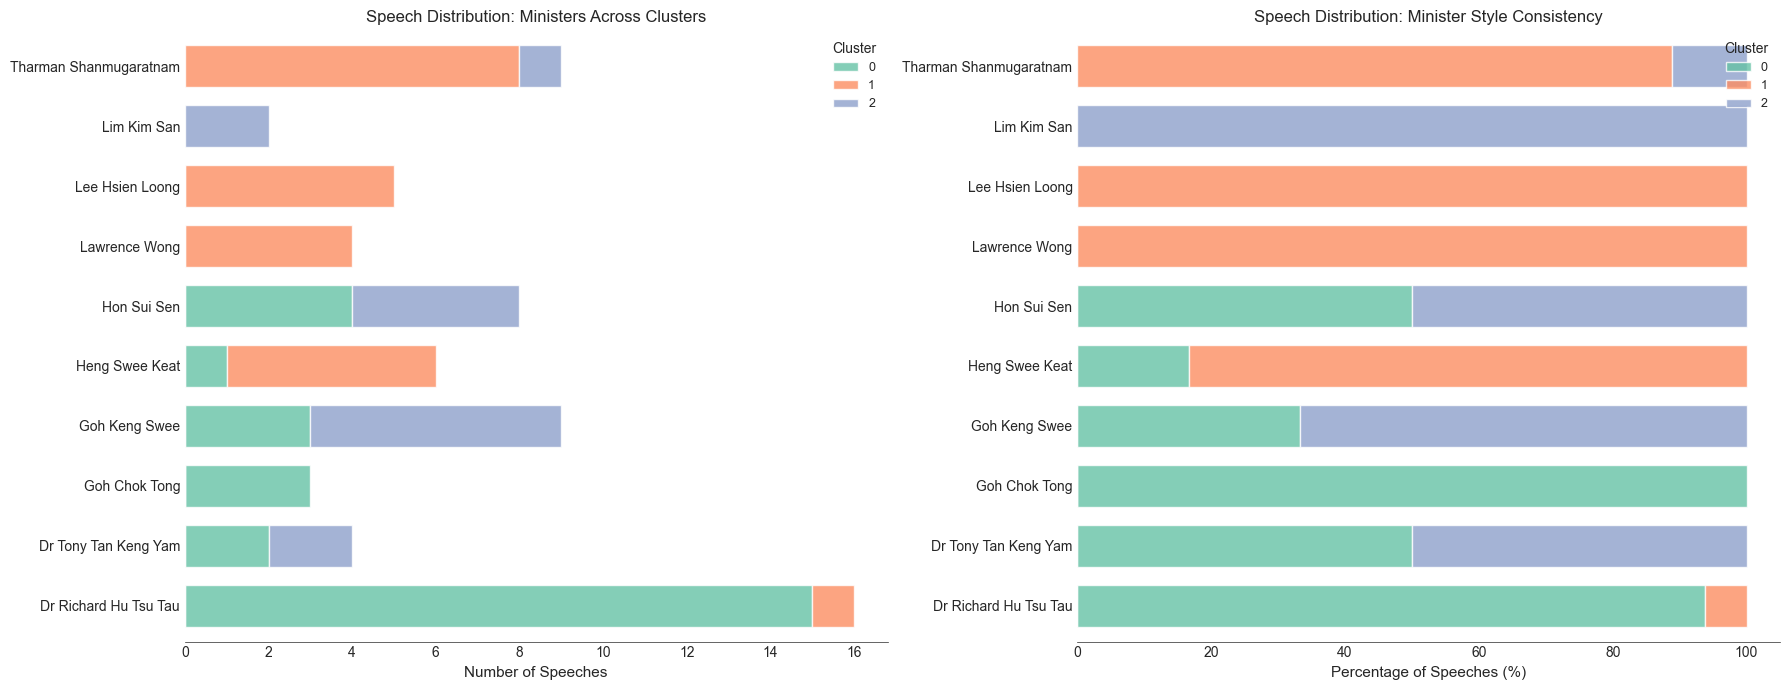


MINISTER STYLE PROFILES

Dr Richard Hu Tsu Tau:
  Total speeches: 16
  Dominant cluster: Cluster 0 (93.8% of speeches)
  Avg speech length: 9,165 words
  Avg readability: 59.0
  Avg words/sentence: 18.2

Dr Tony Tan Keng Yam:
  Total speeches: 4
  Dominant cluster: Cluster 0 (50.0% of speeches)
  Avg speech length: 10,022 words
  Avg readability: 56.8
  Avg words/sentence: 19.6

Goh Chok Tong:
  Total speeches: 3
  Dominant cluster: Cluster 0 (100.0% of speeches)
  Avg speech length: 7,405 words
  Avg readability: 58.9
  Avg words/sentence: 17.8

Goh Keng Swee:
  Total speeches: 9
  Dominant cluster: Cluster 2 (66.7% of speeches)
  Avg speech length: 10,887 words
  Avg readability: 60.9
  Avg words/sentence: 20.6

Heng Swee Keat:
  Total speeches: 6
  Dominant cluster: Cluster 1 (83.3% of speeches)
  Avg speech length: 14,201 words
  Avg readability: 62.1
  Avg words/sentence: 18.0

Hon Sui Sen:
  Total speeches: 8
  Dominant cluster: Cluster 0 (50.0% of speeches)
  Avg speech length:

In [18]:
# Analyze minister patterns within clusters
print("\n" + "="*80)
print("MINISTER CLUSTERING PATTERNS")
print("="*80)

# Count speeches by minister and cluster
minister_cluster_counts = yearly_stats.groupby(['minister', 'cluster']).size().unstack(fill_value=0)

# Calculate percentage distribution for each minister
minister_cluster_pct = minister_cluster_counts.div(minister_cluster_counts.sum(axis=1), axis=0) * 100

print("\nNumber of speeches by minister and cluster:")
print(minister_cluster_counts)
print("\nPercentage distribution (which clusters each minister falls into):")
print(minister_cluster_pct.round(1))

# Visualize minister-cluster relationship
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# 1. Stacked bar chart - absolute counts
minister_cluster_counts.plot(kind='barh', stacked=True, ax=ax1, 
                              color=cluster_colors, alpha=0.8, width=0.7)
ax1.set_xlabel('Number of Speeches', fontsize=11)
ax1.set_ylabel('')
ax1.set_title('Speech Distribution: Ministers Across Clusters', fontsize=12)
ax1.legend(title='Cluster', frameon=False, fontsize=9)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 2. Stacked bar chart - percentages
minister_cluster_pct.plot(kind='barh', stacked=True, ax=ax2, 
                           color=cluster_colors, alpha=0.8, width=0.7)
ax2.set_xlabel('Percentage of Speeches (%)', fontsize=11)
ax2.set_ylabel('')
ax2.set_title('Speech Distribution: Minister Style Consistency', fontsize=12)
ax2.legend(title='Cluster', frameon=False, fontsize=9)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Identify minister tendencies
print("\n" + "="*80)
print("MINISTER STYLE PROFILES")
print("="*80)
for minister in minister_cluster_pct.index:
    dominant_cluster = minister_cluster_pct.loc[minister].idxmax()
    dominant_pct = minister_cluster_pct.loc[minister].max()
    total_speeches = minister_cluster_counts.loc[minister].sum()
    
    print(f"\n{minister}:")
    print(f"  Total speeches: {total_speeches}")
    print(f"  Dominant cluster: Cluster {dominant_cluster} ({dominant_pct:.1f}% of speeches)")
    
    # Get average characteristics for this minister
    minister_avg = yearly_stats[yearly_stats['minister'] == minister][
        ['total_words', 'readability', 'avg_words_per_sentence']
    ].mean()
    print(f"  Avg speech length: {minister_avg['total_words']:,.0f} words")
    print(f"  Avg readability: {minister_avg['readability']:.1f}")
    print(f"  Avg words/sentence: {minister_avg['avg_words_per_sentence']:.1f}")


CLUSTER SEPARATION: KEY FEATURES

Cluster centers (in original units):
           total_words  total_sentences  avg_words_per_sentence  readability
Cluster 0       8507.5            463.1                    18.4         59.0
Cluster 1      14548.4            795.1                    18.3         63.2
Cluster 2      12121.3            563.5                    21.5         57.8


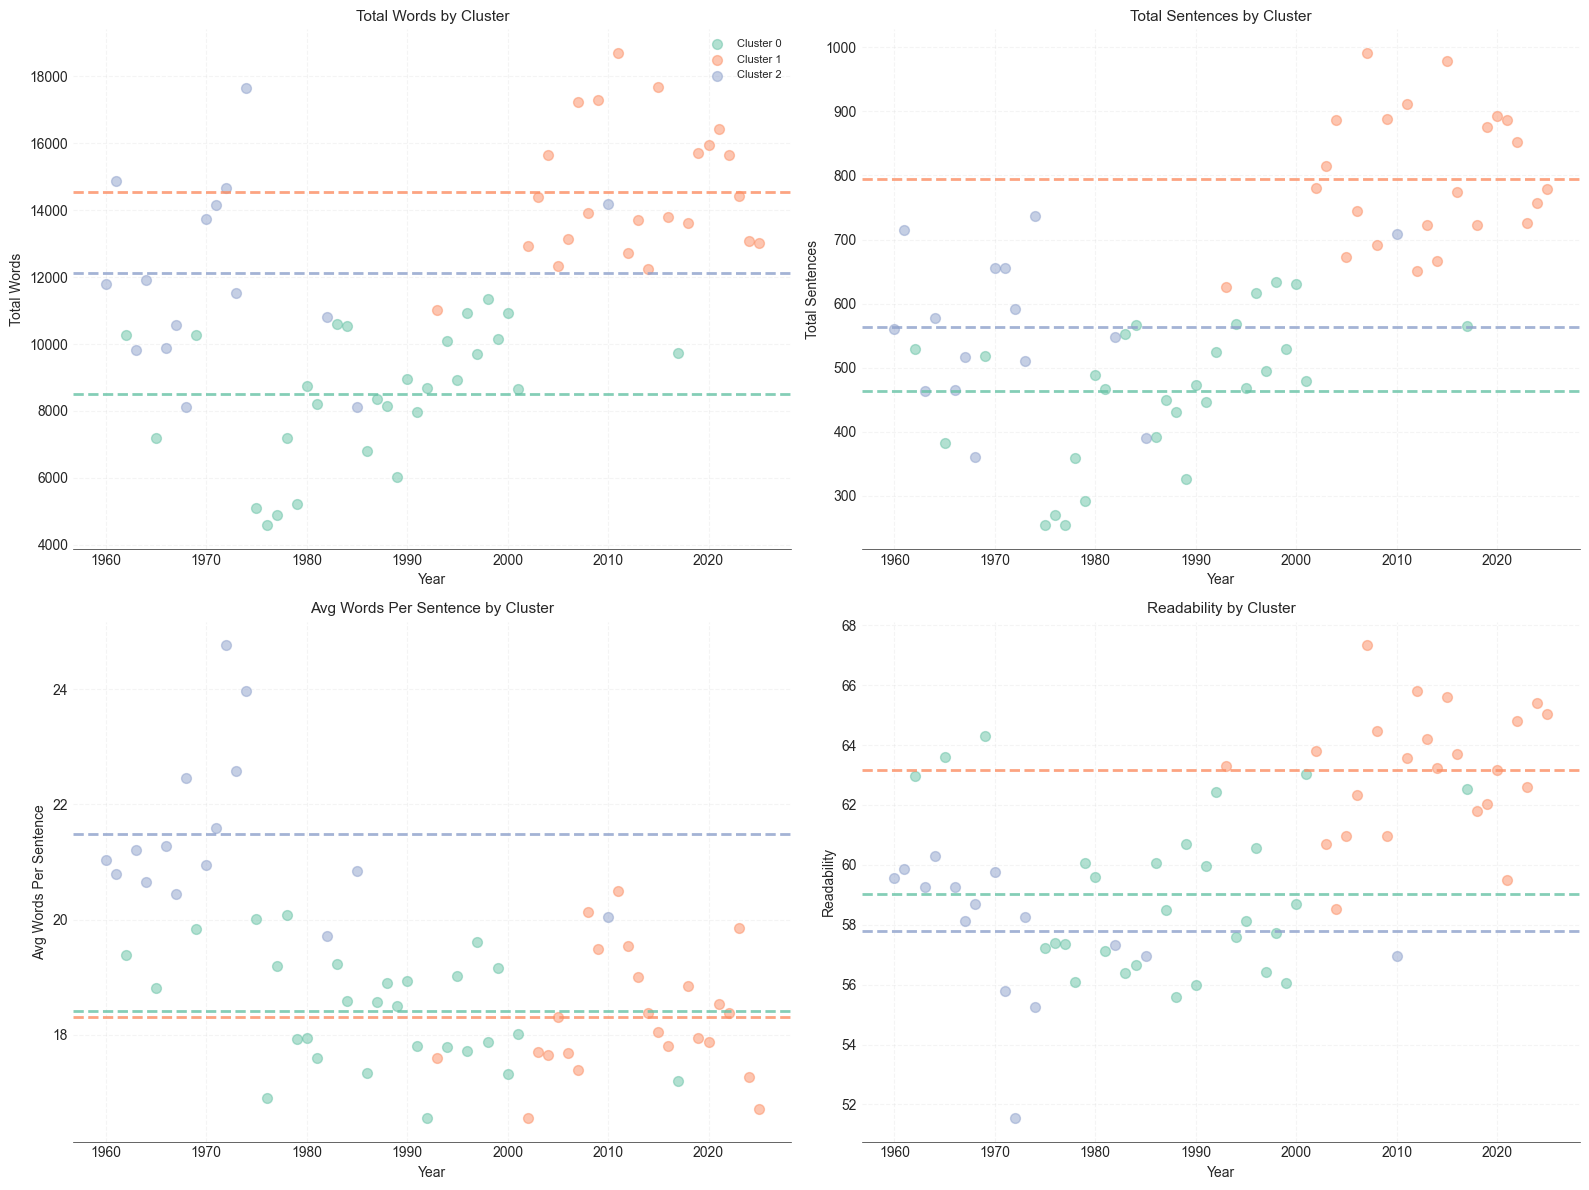


FEATURE CONTRIBUTION TO CLUSTER SEPARATION

Total Words:
  Between-cluster variance: 6160371.96
  Total variance: 11819794.20
  Variance ratio: 0.521 (higher = more separation)

Total Sentences:
  Between-cluster variance: 19332.56
  Total variance: 33618.05
  Variance ratio: 0.575 (higher = more separation)

Avg Words Per Sentence:
  Between-cluster variance: 2.17
  Total variance: 2.92
  Variance ratio: 0.745 (higher = more separation)

Readability:
  Between-cluster variance: 5.28
  Total variance: 10.60
  Variance ratio: 0.498 (higher = more separation)


In [19]:
# Feature importance: Which features contribute most to cluster separation?
print("\n" + "="*80)
print("CLUSTER SEPARATION: KEY FEATURES")
print("="*80)

# Calculate cluster centers in original feature space
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
feature_names = ['total_words', 'total_sentences', 'avg_words_per_sentence', 'readability']

print("\nCluster centers (in original units):")
centers_df = pd.DataFrame(cluster_centers_original, 
                          columns=feature_names,
                          index=[f'Cluster {i}' for i in range(optimal_k)])
print(centers_df.round(1))

# Visualize cluster centers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(feature_names):
    ax = axes[idx]
    
    # Plot all speeches
    for cluster in range(optimal_k):
        cluster_mask = yearly_stats['cluster'] == cluster
        cluster_data = yearly_stats[cluster_mask]
        ax.scatter(cluster_data.index, cluster_data[feature], 
                  c=[cluster_colors[cluster]], s=50, alpha=0.5, 
                  label=f'Cluster {cluster}')
    
    # Add cluster center lines
    for cluster in range(optimal_k):
        cluster_mask = yearly_stats['cluster'] == cluster
        ax.axhline(y=centers_df.loc[f'Cluster {cluster}', feature], 
                  color=cluster_colors[cluster], linestyle='--', 
                  linewidth=2, alpha=0.8)
    
    ax.set_xlabel('Year', fontsize=10)
    ax.set_ylabel(feature.replace('_', ' ').title(), fontsize=10)
    ax.set_title(f'{feature.replace("_", " ").title()} by Cluster', fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.2, linestyle='--')
    
    if idx == 0:
        ax.legend(frameon=False, fontsize=8)

plt.tight_layout()
plt.show()

# Calculate feature variance contribution to clustering
print("\n" + "="*80)
print("FEATURE CONTRIBUTION TO CLUSTER SEPARATION")
print("="*80)

# Calculate between-cluster variance for each feature
for feature in feature_names:
    cluster_means = []
    for cluster in range(optimal_k):
        cluster_mask = yearly_stats['cluster'] == cluster
        cluster_means.append(yearly_stats[cluster_mask][feature].mean())
    
    overall_mean = yearly_stats[feature].mean()
    between_var = np.var(cluster_means)
    within_var = yearly_stats[feature].var()
    
    print(f"\n{feature.replace('_', ' ').title()}:")
    print(f"  Between-cluster variance: {between_var:.2f}")
    print(f"  Total variance: {within_var:.2f}")
    print(f"  Variance ratio: {between_var/within_var:.3f} (higher = more separation)")

## Summary Statistics

Key findings from the analysis.

In [20]:
print("=" * 70)
print("SINGAPORE BUDGET SPEECHES ANALYSIS SUMMARY (1960-2025)")
print("=" * 70)

print("\n1. SPEECHES BY MINISTER")
print("-" * 70)
for minister, count in speeches_by_minister.items():
    years = yearly_stats[yearly_stats['minister'] == minister].index.tolist()
    year_range = f"{min(years)}-{max(years)}" if years else "N/A"
    print(f"  {minister:30s}: {count:2d} speeches ({year_range})")

print("\n2. SPEECH LENGTH TRENDS")
print("-" * 70)
print(f"  Shortest speech: {yearly_stats['total_words'].min():,.0f} words in {yearly_stats['total_words'].idxmin()}")
print(f"  Longest speech:  {yearly_stats['total_words'].max():,.0f} words in {yearly_stats['total_words'].idxmax()}")
print(f"  Average speech:  {yearly_stats['total_words'].mean():,.0f} words")
print(f"  Median speech:   {yearly_stats['total_words'].median():,.0f} words")

print("\n3. SENTENCE CHARACTERISTICS")
print("-" * 70)
print(f"  Overall avg words/sentence: {yearly_stats['avg_words_per_sentence'].mean():.1f}")
print(f"  Range: {yearly_stats['avg_words_per_sentence'].min():.1f} - {yearly_stats['avg_words_per_sentence'].max():.1f} words/sentence")

print("\n4. DATASET SUMMARY")
print("-" * 70)
print(f"  Total years covered: {len(yearly_stats)}")
print(f"  Total sentences: {df_all.shape[0]:,}")
print(f"  Total words: {yearly_stats['total_words'].sum():,.0f}")
print(f"  Total ministers: {len(speeches_by_minister)}")

print("\n" + "=" * 70)

SINGAPORE BUDGET SPEECHES ANALYSIS SUMMARY (1960-2025)

1. SPEECHES BY MINISTER
----------------------------------------------------------------------
  Dr Richard Hu Tsu Tau         : 16 speeches (1986-2001)
  Goh Keng Swee                 :  9 speeches (1960-1970)
  Tharman Shanmugaratnam        :  9 speeches (2007-2015)
  Hon Sui Sen                   :  8 speeches (1971-1978)
  Heng Swee Keat                :  6 speeches (2016-2021)
  Lee Hsien Loong               :  5 speeches (2002-2006)
  Dr Tony Tan Keng Yam          :  4 speeches (1982-1985)
  Lawrence Wong                 :  4 speeches (2022-2025)
  Goh Chok Tong                 :  3 speeches (1979-1981)
  Lim Kim San                   :  2 speeches (1966-1967)

2. SPEECH LENGTH TRENDS
----------------------------------------------------------------------
  Shortest speech: 4,579 words in 1976
  Longest speech:  18,699 words in 2011
  Average speech:  11,434 words
  Median speech:   10,968 words

3. SENTENCE CHARACTERISTICS
-

## Export Results

Save the analysis results to CSV files for future reference.

In [21]:
# Save yearly statistics
output_file = Path.cwd() / 'yearly_speech_statistics.csv'
yearly_stats.to_csv(output_file)
print(f"✓ Yearly statistics saved to: {output_file.name}")

# Save minister statistics
minister_file = Path.cwd() / 'minister_speech_statistics.csv'
minister_stats.to_csv(minister_file)
print(f"✓ Minister statistics saved to: {minister_file.name}")

print("\nAnalysis complete! 🎉")

✓ Yearly statistics saved to: yearly_speech_statistics.csv
✓ Minister statistics saved to: minister_speech_statistics.csv

Analysis complete! 🎉
